In [1]:
from qiskit import *
from qiskit import IBMQ, Aer

from qiskit.circuit import ParameterVector
from qiskit.visualization.bloch import Bloch
from qiskit.aqua.components.optimizers import SPSA
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import math
import time
import pickle
import random 
from random import randrange

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

#### Script parameters

In [3]:
quantum_hw = 0
bknd = 'ibmq_athens'
Shots = 8192                        #number of attempts for each measuration to get a statistical result
max_circuits_supported = 7400         #use an number multiple of number_classes
layout = [0,1]

number_training = 200 #100               #number of events of each type used during the training phase
number_testing = 200  #1000               #number of events of each type used during the testing phase
SPSA_steps = 100    #200                    #number of steps for SPSA algorithm (original: 100)
number_var = 2                     #total number of variables used to classify each event
number_classes = 2                  #number of classes for which classification is performed
ratio = 1 #0.18145139685943007         #ratio probability_signal/ probability_event

#numbers associated to the variables used for the classification of each event (their order is relevant):
ii = 35
jj = 40


c_e_ii = 23.807574615434635
c_e_jj = 8.177020948034661
                                                                                    


L1 = 1                 #Number of repetitions of the Mapping Circuit
L2 = 2                 #Number of repetitions of the Variational part of the Quantum Circuit


print_loss_func = 1     #1: prints the loss function evaluations, 0: doesn't
plot_AUC_image = 1      #1: prints the AUC graph, 0: doesn't
plot_data = 1           #1: prints the data images, 0: doesn't

#### Definitions of useful functions

In [4]:
def Cheb(x):
    return np.cos((x+1)*np.pi/2)

def InvCheb(x):
    return 2*np.arccos((x+1)/2)/np.pi-1

def Sqrt(x):
    x = np.clip(x,-1,1)
    return np.sqrt((x+1)/2)*2 -1

def InvSqrt(x):
    return ((x+1)**2 -1)/2

In [5]:
def f_label(i):
    if i%2==0:
        result = [1,0]
    else:
        result = [0,1]
    return result

In [6]:
def softmax_function(x):#IMPLEMENTED ONLY FOR 2 BITS
    F = [math.exp(x[0]),math.exp(x[1])]
    F = np.array(F)/sum(F)
    return F
  
#the following gives a two dimensional unitary vector obtained from results of measurations from the qubits     
def f_measuration(count):
    Z_m = np.zeros(2)
    for i in range(0,2**(number_bits)):
        for k in range(0,2):
            if eig[i][1-k] == '0' and eig[i] in count:
                Z_m[k] += count[eig[i]]  

    Z_m = (2*np.array(Z_m)-Shots)/Shots
    y = softmax_function(Z_m)
    return y

In [7]:
#definition of the mapping auxiliary function phi 
def Phi_function(x,y):
    return [np.arcsin(y),np.arccos(y**2),np.arcsin(x),np.arccos(x**2)] 
    #the length of the array has to be equal to the number of qubits

In [8]:
def training_set(par,circuit,theta,Phi_f):
    #the following lines are destineted to the creation of the input for bind.parameters()
    pre_input = [[theta.params[k], par[k]] for k in range(0, number_parameters)]
    input_p2 = []
    for i in range(0,len(pre_input)):
        input_p2 = input_p2  + [pre_input[i][0]] + [pre_input[i][1]]
    the_input = [{Phi:Phi_f[i]} for i in range(0,len(X))]
    for i in range(0,len(X)):
        for j in range(0,len(pre_input)):
            the_input[i][pre_input[j][0]] = pre_input[j][1]

    #evaluation of the circuit with the parameters setted by the input, for all possible values in X
    Counts = []
    for j in range(0,N):
        circuits_dataset = [circuit.bind_parameters(the_input[i+j*max_circuits_supported]) for i in range(0,max_circuits_supported)]
        if quantum_hw == 1:
            provider = IBMQ.get_provider('ibm-q')
            qcomp = provider.get_backend(bknd)
        else:
            qcomp = Aer.get_backend('qasm_simulator')
        job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
        job_monitor(job)
        result = job.result()
        counts = result.get_counts()
        Counts = Counts + counts

    circuits_dataset = [circuit.bind_parameters(the_input[i+max_circuits_supported*N]) for i in range(0,remainder)]
    if quantum_hw == 1:
        provider = IBMQ.get_provider('ibm-q')
        qcomp = provider.get_backend(bknd)
    else:
        qcomp = Aer.get_backend('qasm_simulator')
    job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts()

    Counts = Counts + counts
    counts = Counts
    
    ### Just to check that the circuits look right...
    print(circuits_dataset[0].decompose())
    
    return counts

<IPython.core.display.Javascript object>


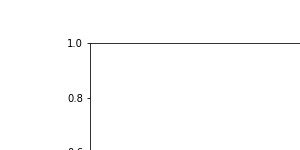

In [9]:
%matplotlib notebook

X_plot = []
Y_plot = []

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
iter_count = 0

def plot_cost_fun(y):
    global iter_count
    global X_plot
    global Y_plot
    X_plot.append(iter_count)
    Y_plot.append(y)
    ax.clear()
    ax.plot(X_plot,Y_plot)
    fig.canvas.draw()
    iter_count += 1   
    


def cost_function(par,*args): #par will contain the parameters at each step of the optimization

    circuit = args[0]
    theta = args[1]
    Phi_f = args[2]
    
    counts = training_set(par,circuit,theta,Phi_f)

    L = 0
    print("\n current value of parameters: " , par )
        
    #estimated label 
    for i in range(0,len(X)):
        for k in range(0,2):
            yi = f_measuration(counts[i])
            L += -f_l[i][k]*math.log(yi[k])
            
    if print_loss_func == 1:
        plot_cost_fun(L)
    
    print("current value for loss function: " , L , "\n\n" )
    return L

#### Loading data for training

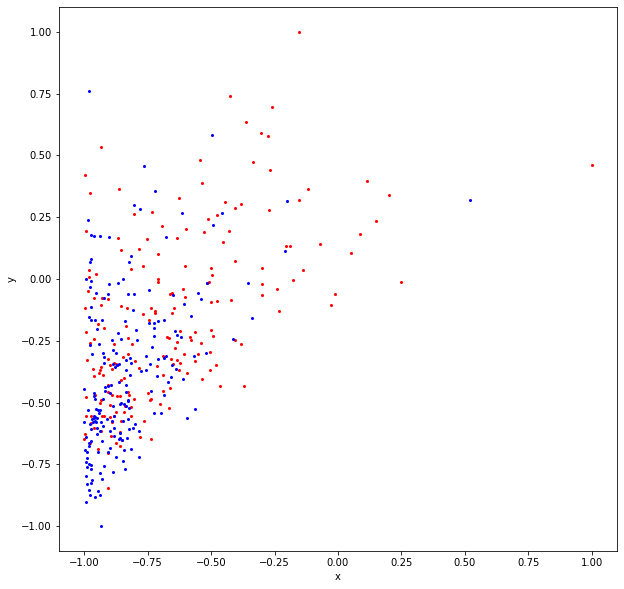

In [10]:
#DATA CAPTURE
#Here data are normalized in [-1,1] and, eventually, "stretched" or "squized" by using the previous functions.
#Odd and even elements of the following vectors will apparain to different classes (by choice)

data2 = pickle.load(open("background_balanced.pkl","rb"))
data1 = pickle.load(open("signal_balanced.pkl","rb"))
Ind = data1.columns
n = 0 #number_testing
#start = randrange(8000)
start = 0

X1 = np.array(data1[Ind[ii]])
X2 = np.array(data2[Ind[ii]])

XX = []
for i in range(start, start + number_training + n):
    XX.append(X1[i])
    XX.append(X2[i])

Xmax = max(max(XX),max(XX))
Xmin = min(min(XX),min(XX))

X = []
for i in range(0,number_training):
    X.append(X1[i])
    X.append(X2[i])

#X are normalizated over [-1,1]
if Xmax-Xmin!= 0:
    X = (np.array(X)- Xmin)*2/(Xmax-Xmin)
X = np.array(X) -1
#X = Sqrt(X)
X = np.clip(X,-1,1)

############################################################

Y1 = np.array(data1[Ind[jj]])
Y2 = np.array(data2[Ind[jj]])

YY = []
for i in range(start, start + number_training + n):
    YY.append(Y1[i])
    YY.append(Y2[i])

Ymax = max(max(YY),max(YY))
Ymin = min(min(YY),min(YY))


Y = []
for i in range(0,number_training):
    Y.append(Y1[i])
    Y.append(Y2[i])

#Y are normalizated over [-1,1]
if Ymax-Ymin!= 0:
    Y = (np.array(Y)- Ymin)*2/(Ymax-Ymin)
Y = np.array(Y)  -1
Y = Sqrt(Y)
Y = np.clip(Y,-1,1)

############################################################



X1 = []
X2 = []
Y1 = []
Y2 = []


for i in range(0,len(X)):
    if i % 2 == 0:
        X1.append(X[i])
        Y1.append(Y[i])

    else:
        X2.append(X[i])
        Y2.append(Y[i])

%matplotlib inline
#TRAINING SET VISUALIZATION
if plot_data == 1:
    fig = plt.figure(figsize = (10,10)) 
    ax = plt.axes()
    ax.plot(X1,Y1,'ro',markersize = 2)
    ax.plot(X2,Y2,'bo',markersize = 2)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')     

#### Preparing for the training

In [11]:
#this part of the program is needed in the case where there exists a maximal number of trainable circuits per-time
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

In [12]:
number_qubits = 1 #for EACH variable
number_bits = number_classes

#evaluation of phi
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i])[j]

In [13]:
#defining the label function for the trainingset, remember that odd and even events correspond to different classes

f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

#### Build the variational circuit

In [14]:
number_parameters = 4*number_qubits*number_var

Phi = ParameterVector('Φ', 2*number_var) #int(number_qubits*(number_qubits+1)/2)
theta = ParameterVector('θ',number_parameters)

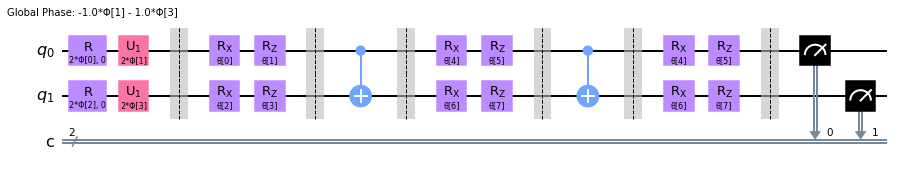

In [15]:
circuit = QuantumCircuit(number_var*number_qubits, number_bits)

for i in range(0,L1):

    for j in range(0,number_var):
        for k in range(0,number_qubits):
            circuit.rx(2*Phi[j*2],j+(number_var)*k)  
            circuit.rz(2*Phi[j*2+1],j+(number_var)*k) 
circuit.barrier()

#rotations
s = 0
for i in range(0,number_qubits*number_var):
    variational_circuit = QuantumCircuit(1)
    variational_circuit.rx(theta[s],0)
    s += 1
    variational_circuit.rz(theta[s],0)
    s += 1
    var_inst = variational_circuit.to_instruction()

    circuit.append(var_inst,[i])
circuit.barrier()
S = s

for k in range(0,L2):    
    #entanglement  
 
    circuit.cx(0,1)


    
    circuit.barrier()
    
    #rotations
    s = S
    for i in range(0,number_qubits*number_var):
        variational_circuit = QuantumCircuit(1)
        variational_circuit.rx(theta[s],0)
        s += 1
        variational_circuit.rz(theta[s],0)
        s += 1
        var_inst = variational_circuit.to_instruction()

        circuit.append(var_inst,[i])
    circuit.barrier()

    
circuit.measure(range(0,2),range(0,2))

decomposed_circuit = circuit.decompose()
decomposed_circuit.draw('mpl')

#### Training

In [16]:
factor = 100

#creation of the eigenstates list, i.e: ['000', '001',... ]
eig = []
for i in range(0,2**(number_bits)):
    eig.append('')

for j in range(0,number_bits):
    for i in range(0,2**j): 
        for k in range(0,(2**(number_bits-j))):            
            if (k % 2) == 0:
                eig[i+k*2**j] = '0' + eig[i+k*2**j] 
            else:
                eig[i+k*2**j] = '1' + eig[i+k*2**j]    

In [17]:
#initial values for parameters are chosen randomly
theta_0 = []

for i in range(0, number_parameters):
    theta_0.append(random.uniform(0, 2*np.pi))
theta_0 = np.array(theta_0)

#In the following c0 is the firt step "a", c1 is the initial "c", c2 is the "alpha" parameter, c3 the "gamma" parameter
#and finally c4 another parameter to control "a" (as like as "alpha" does)
t = time.time()

Optimizer = SPSA(max_trials = 1e3, save_steps = 1, last_avg = 1, c0 = 10/(number_training), c1 = 0.3, c2 = 1, c3 = 0.7, c4 = 0, 
                 skip_calibration = False)

# cost_final, theta_best, cost_plus_save, cost_minus_save, theta_plus_save, theta_minus_save =  (
#     Optimizer._optimization(cost_function,theta_0, SPSA_steps, save_steps = 1, last_avg = 3))

fw = Optimizer.wrap_function(cost_function,(circuit,theta,Phi_f))

cost_final, theta_best, cost_plus_save, cost_minus_save, theta_plus_save, theta_minus_save =  (
    Optimizer._optimization(fw,theta_0, SPSA_steps, save_steps = 1, last_avg = 3) )

print(cost_final,theta_best)

elapsed = time.time() - t
print(elapsed)
%matplotlib inline

C:\Users\dado\anaconda3\lib\site-packages\qiskit\aqua\components\optimizers\spsa.py:93: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  warnings.warn('The max_trials parameter is deprecated as of '


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(3.00709526136814) ├┤ RZ(2.48891695389408) ├─░───■───░─»
«     ├──────────────────────┤├──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(5.74704244219083) ├┤ RZ(3.19717734978479) ├─░─┤ X ├─░─»
«     └──────────────────────┘└──────────────────────┘ ░ └───┘ ░ »
«c: 2/═══════════════════════════════════════════════════════════»
«                                                                »
«     ┌─────────────────────

current value for loss function:  326.74668447120763 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(4.96732408449917) ├┤ RZ(4.44914577702511) ├─░───■───░─»
«     ├──────────────────────┤├──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(6.98571189354548) ├┤ RZ(1.95850789843014) ├─░─┤ X ├─░─»
«     └──────────────────────┘└──────────────────────┘ ░ └───┘ ░ »
«c: 2/═══════════════════════════════════════════════════════════»
«                                      

 current value of parameters:  [6.92332505e+00 6.63250423e+00 8.94171286e+00 2.50693453e-03
 2.26603630e+00 7.52220005e+00 2.03849886e+00 3.97232046e+00]
current value for loss function:  331.1479340265961 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐  ░       ░ »
«q_0: ┤ RX(7.63708855364311) ├─┤ RZ(5.72426192906135) ├──░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┴┐ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(9.84995515429254) ├┤ RZ(-0.905735362316923) ├─░─┤ X ├─░─»
«     └─────

current value for loss function:  267.65813470621316 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐  ░       ░ »
«q_0: ┤ RX(6.87505476649047) ├─┤ RZ(6.17577251733552) ├──░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┴┐ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.7656566525184) ├┤ RZ(-0.607892485115987) ├─░─┤ X ├─░─»
«     └──────────────────────┘└────────────────────────┘ ░ └───┘ ░ »
«c: 2/═════════════════════════════════════════════════════════════»
«                          

current value for loss function:  294.3833484646104 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(6.66491257510675) ├─┤ RZ(5.96563032595179) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(9.47473769271683) ├┤ RZ(0.683026474685595) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                 

current value for loss function:  273.186244307562 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(6.44986701026210) ├─┤ RZ(6.29007924105551) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(9.91117586674739) ├┤ RZ(0.358577559581876) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                  

current value for loss function:  281.4264954697968 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(6.55706294316271) ├─┤ RZ(7.13134502905099) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(9.91874162221315) ├┤ RZ(0.465773492482483) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                 


 current value of parameters:  [ 6.29661014  6.9654858  10.17919443  0.20532069  1.63993163  8.53232044
  1.09172223  4.02809476]
current value for loss function:  263.22554066655084 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(6.18332975497978) ├─┤ RZ(7.07876618074260) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.2924748103961) ├┤ RZ(0.182174039533264) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────

current value for loss function:  261.16177717995186 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(6.16564195802302) ├─┤ RZ(7.09726028847296) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.3927354061887) ├┤ RZ(0.199861836490032) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  255.5939042417265 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.84024717729252) ├─┤ RZ(6.77186550774247) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0673406254582) ├┤ RZ(0.448868865173549) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                 

current value for loss function:  255.02508353286913 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.73112914866605) ├─┤ RZ(6.81194696673937) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(9.95822259683169) ├┤ RZ(0.410970143648228) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  252.85059355486655 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.74894744371050) ├─┤ RZ(6.95353209420373) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0998077242961) ├┤ RZ(0.393151848603785) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  250.92119987224433 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.77876732700660) ├─┤ RZ(6.96616818070956) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0665909402865) ├┤ RZ(0.380515762097955) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  250.71734347885166 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.71803675984986) ├─┤ RZ(6.93369215367494) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0393364033317) ├┤ RZ(0.441246329254696) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  250.62471723155676 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.76016433600352) ├─┤ RZ(6.93982583725283) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0246477182434) ├┤ RZ(0.399118753101036) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  250.90994650786214 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.73901848029110) ├─┤ RZ(6.99505200647696) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0798738874675) ├┤ RZ(0.400120109110253) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  250.5308949061774 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.67031060628799) ├─┤ RZ(6.98776902720151) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0725909081921) ├┤ RZ(0.468827983113359) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                 


 current value of parameters:  [ 5.71906316  6.98984599 10.02383835  0.42007543  1.47352506  8.64753787
  0.78646894  4.04553939]
current value for loss function:  250.3811046869585 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.72250989940644) ├─┤ RZ(6.99329272859163) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0702001330035) ├┤ RZ(0.416628689994910) ├─░─┤ X ├─░─»
«     └──────────────────────┘└────────


 current value of parameters:  [ 5.67206282  6.94284565 10.06858899  0.41823983  1.47168947  8.64570227
  0.83121958  4.09029003]
current value for loss function:  250.4076755549653 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.71086956562015) ├─┤ RZ(6.98165239480534) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0776904696859) ├┤ RZ(0.457046574230195) ├─░─┤ X ├─░─»
«     └──────────────────────┘└────────


 current value of parameters:  [ 5.65984799  6.93063082 10.0266689   0.45304718  1.46658739  8.68050962
  0.84343441  4.09539211]
current value for loss function:  250.42598577726287 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.65354606250717) ├─┤ RZ(6.92432889169235) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0665418731536) ├┤ RZ(0.413174199575639) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────


 current value of parameters:  [ 5.64029295  6.95643956 10.07979499  0.44528487  1.49239613  8.62738353
  0.8356721   4.0876298 ]
current value for loss function:  250.27308107820664 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.63965779798551) ├─┤ RZ(6.91248829955390) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0804301376753) ├┤ RZ(0.401333607437187) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────


 current value of parameters:  [ 5.63755132  6.95422245 10.03869599  0.44306775  1.49513776  8.62464189
  0.78961436  4.09037143]
current value for loss function:  250.37530337518834 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.67525979789372) ├─┤ RZ(6.91651396860321) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0332800422330) ├┤ RZ(0.405359276486493) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────


 current value of parameters:  [ 5.67321096  6.91856281 10.07776487  0.44984411  1.50191411  8.66030153
  0.82868325  4.09714778]
current value for loss function:  250.6899069791376 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.61443569082053) ├─┤ RZ(6.93556441922670) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0189896048662) ├┤ RZ(0.391068839119703) ├─░─┤ X ├─░─»
«     └──────────────────────┘└────────


 current value of parameters:  [ 5.6551474   6.97627613 10.01856543  0.43178055  1.44271467  8.60110209
  0.81061969  4.07908422]
current value for loss function:  250.41873752065777 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.65530631559105) ├─┤ RZ(6.93591380185222) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0184065156444) ├┤ RZ(0.391418221745223) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────


 current value of parameters:  [ 5.60208484  6.94920683 10.03169954  0.44463969  1.46978397  8.65416465
  0.79748557  4.05201493]
current value for loss function:  250.15848190824178 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.60024431719323) ├─┤ RZ(6.94736630581684) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0298590196090) ├┤ RZ(0.407123944432231) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────


 current value of parameters:  [ 5.62966691  6.9767889  10.02047799  0.43654653  1.48100552  8.66538621
  0.78939241  4.06010809]
current value for loss function:  250.27543062852575 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.58306548629305) ├─┤ RZ(6.96845691667131) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0670794098819) ├┤ RZ(0.428214555286709) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────

current value for loss function:  250.0893319052068 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.61357876640847) ├─┤ RZ(6.97343104715518) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0365661297665) ├┤ RZ(0.434954008337732) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                 

current value for loss function:  249.9837296532228 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.56715491007234) ├─┤ RZ(6.92297573454945) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0507222161245) ├┤ RZ(0.384498695731999) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                 

current value for loss function:  249.89442631217182 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.56482832733259) ├─┤ RZ(6.95605205287333) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0837985344484) ├┤ RZ(0.374126003780421) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.7622902550838 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.59283622577448) ├─┤ RZ(6.92360821297055) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0557906360065) ├┤ RZ(0.406569843683195) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                 

 current value of parameters:  [ 5.60320911  6.91323533 10.07957205  0.41694273  1.40287682  8.64134646
  0.78794308  4.10619782]
current value for loss function:  249.89003799589284 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.56937230730480) ├─┤ RZ(6.94707213144023) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0794966399345) ├┤ RZ(0.383105925213517) ├─░─┤ X ├─░─»
«     └──────────────────────┘└────────

current value for loss function:  249.931480768573 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.56346896220447) ├─┤ RZ(6.90881535992913) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0742473861937) ├┤ RZ(0.421362696724615) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                  

current value for loss function:  249.81173552804745 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.59501571977162) ├─┤ RZ(6.94036211749628) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0745480798370) ├┤ RZ(0.389370129510029) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  250.19172233177366 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.54853094094264) ├─┤ RZ(6.92549275377915) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0280633010080) ├┤ RZ(0.379997883052502) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.62729808083313 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.56973432946903) ├─┤ RZ(6.93526048353811) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0366294579399) ├┤ RZ(0.388564039984350) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.44444120319054 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.52778626839870) ├─┤ RZ(6.91699529721063) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0548946442673) ├┤ RZ(0.430512101054673) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.52228554533582 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.55748197704132) ├─┤ RZ(6.96129587095649) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0251989356247) ├┤ RZ(0.415984709039946) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.24763044358974 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.56275209903037) ├─┤ RZ(6.96656599294554) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0199288136357) ├┤ RZ(0.380219590353127) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.3604298496057 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.53705297891340) ├─┤ RZ(6.94086687282857) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0169460452792) ├┤ RZ(0.405918710470097) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                 

current value for loss function:  249.46026964164238 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.53381359633607) ├─┤ RZ(6.93762749025123) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0163080241755) ├┤ RZ(0.409158093047436) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.40280935923576 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.55774586441353) ├─┤ RZ(6.93387684855946) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0130096969964) ├┤ RZ(0.385225824969972) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.35483821335546 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.55383368693949) ├─┤ RZ(6.96462882389955) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0441361379846) ├┤ RZ(0.389138002444014) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.07344455948996 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.53256544866631) ├─┤ RZ(6.94071245296084) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0469841972740) ├┤ RZ(0.383641810489058) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.36570767656127 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.53864923285629) ├─┤ RZ(6.97062627818117) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0170703720537) ├┤ RZ(0.389725594679033) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.18022253086974 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.55840299267978) ├─┤ RZ(6.98100316847554) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0326100948825) ├┤ RZ(0.383562741379310) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.07737954485557 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.55815616636996) ├─┤ RZ(6.94942448685418) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0265479821282) ├┤ RZ(0.409326136556174) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

current value for loss function:  249.43652292179422 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.56917350534038) ├─┤ RZ(6.96353834556923) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0025152241884) ├┤ RZ(0.410424576301846) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

 0.82577923 4.1372626 ]
current value for loss function:  249.22239775335257 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.54828681765779) ├─┤ RZ(6.94265165788665) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(9.99864224901873) ├┤ RZ(0.411862096848040) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«        

current value for loss function:  249.40791269812587 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.54211935377500) ├─┤ RZ(6.96088538567929) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0209940721102) ├┤ RZ(0.393628369055400) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                

 current value of parameters:  [ 5.56201668  6.96521469 10.00109674  0.4135257   1.29837552  8.63569409
  0.81317505  4.12975825]
current value for loss function:  249.1052047708413 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.56457840965820) ├─┤ RZ(6.94372134602728) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0225900856251) ├┤ RZ(0.392032355540539) ├─░─┤ X ├─░─»
«     └──────────────────────┘└─────────

 current value of parameters:  [5.53594895 6.97235081 9.99396063 0.39677538 1.31512583 8.61894378
 0.80603894 4.13193955]
current value for loss function:  249.04811294471 


Job Status: job has successfully run
global phase: -1.92982197944872
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ »
q_0: ┤ R(-0.755654481302996,0) ├─┤ U1(2.86856832798424) ├─░─»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ »
q_1: ─┤ R(-2.43322703314937,0) ├┤ U1(0.991075630913207) ├─░─»
      └────────────────────────┘└───────────────────────┘ ░ »
c: 2/═══════════════════════════════════════════════════════»
                                                            »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.54755731920545) ├─┤ RZ(6.96074243648003) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0055689951723) ├┤ RZ(0.405277947637407) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────

#### Load data for testing

In [18]:
#data capture
# data2 = pickle.load(open("Wjets_part1.pkl","rb"))
# data1 = pickle.load(open("VBS_part1.pkl","rb"))
# Ind = data1.columns


X1 = np.array(data1[Ind[ii]])
X2 = np.array(data2[Ind[ii]])

X = []
for i in range(start + number_training, start + number_training + number_testing):
    X.append(X1[i])
    X.append(X2[i])

#X are normalizated over [-1,1]
if Xmax-Xmin!= 0:
    X = (np.array(X)- Xmin)*2/(Xmax-Xmin)
X = np.array(X) -1
#X = Sqrt(X)
X = np.clip(X,-1,1)

############################################################

Y1 = np.array(data1[Ind[jj]])
Y2 = np.array(data2[Ind[jj]])


Y = []
for i in range(start + number_training, start + number_training + number_testing):
    Y.append(Y1[i])
    Y.append(Y2[i])

#Y are normalizated over [-1,1]
if Ymax-Ymin!= 0:
    Y = (np.array(Y)- Ymin)*2/(Ymax-Ymin)
Y = np.array(Y)-1
Y = Sqrt(Y)
Y = np.clip(Y,-1,1)

############################################################


X1 = []
X2 = []
Y1 = []
Y2 = []


for i in range(0,len(X)):
    if i % 2 == 0:
        X1.append(X[i])
        Y1.append(Y[i])

    else:
        X2.append(X[i])
        Y2.append(Y[i])


#TESTING SET VISUALIZATION
if plot_data == 1:
    %matplotlib inline
    fig = plt.figure(figsize = (10,10)) 
    ax.plot(X1,Y1,'ro',markersize = 0.5)
    ax.plot(X2,Y2,'bo',markersize = 0.5)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')   

<Figure size 720x720 with 0 Axes>

#### Preparing for testing

In [19]:
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

In [20]:
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i])[j]

In [21]:
f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

#### Testing & AUC

Job Status: job has successfully run
global phase: -2.64592746433449
     ┌─────────────────────────┐┌──────────────────────┐ ░ »
q_0: ┤ R(-0.573051958046959,0) ├┤ U1(2.98167241894117) ├─░─»
     └┬────────────────────────┤├──────────────────────┤ ░ »
q_1: ─┤ R(-1.37726051014608,0) ├┤ U1(2.31018250972782) ├─░─»
      └────────────────────────┘└──────────────────────┘ ░ »
c: 2/══════════════════════════════════════════════════════»
                                                           »
«     ┌──────────────────────┐ ┌──────────────────────┐ ░       ░ »
«q_0: ┤ RX(5.54755731920545) ├─┤ RZ(6.96074243648003) ├─░───■───░─»
«     ├──────────────────────┤┌┴──────────────────────┤ ░ ┌─┴─┐ ░ »
«q_1: ┤ RX(10.0055689951723) ├┤ RZ(0.405277947637407) ├─░─┤ X ├─░─»
«     └──────────────────────┘└───────────────────────┘ ░ └───┘ ░ »
«c: 2/════════════════════════════════════════════════════════════»
«                                                                 »
«      ┌────────────────────

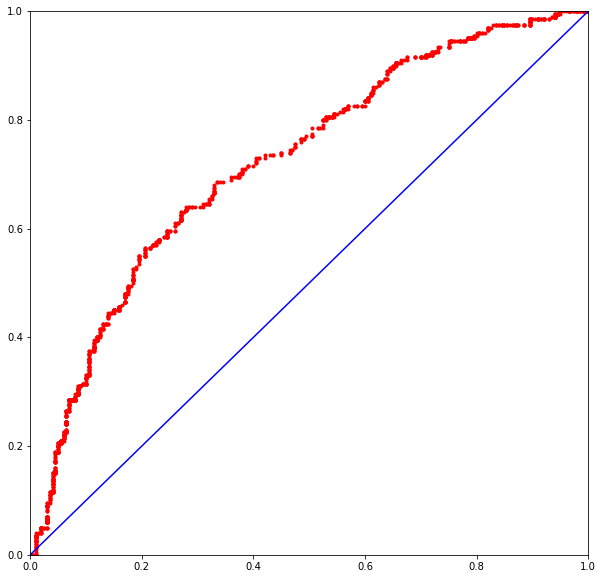

In [22]:
if plot_AUC_image == 1:
    fig2 = plt.figure(figsize = (10,10)) 
    plt.ylim((0,1))
    plt.xlim((0,1))

counts = training_set(theta_best,circuit,theta,Phi_f)

index_sorted = []
classification = []
for i in range(0,len(X)):
    classification.append((f_measuration(counts[i])[0]))

sort_index = np.argsort(classification)

Classification = []
Labelling = []
for i in range(0,len(X)):
    Classification.append((f_measuration(counts[sort_index[i]])[0]))
    Labelling.append((sort_index[i]+1)%2)

treshold = np.linspace(0,1,2000)
False_positive_rate = []
True_positive_rate = []

for k in range(0,len(treshold)):
    C = Classification > treshold[k]
    false_negatives = sum((Labelling - C) == np.int_(np.ones(len(X))))
    false_positives = sum(np.array(Labelling - C) ==np.int_(-np.ones(len(X))))
    true_positives = sum(Labelling) - false_negatives 
    true_negatives = sum((Labelling) == np.int_(np.zeros(len(X)))) - false_positives

    False_positive_rate.append(false_positives/(false_positives+true_negatives+0.000001))
    True_positive_rate.append(true_positives/(true_positives+false_negatives+0.000001))
    if plot_AUC_image == 1:
        plt.plot(False_positive_rate[k],True_positive_rate[k],'ro',label = "ROC", markersize=3)
        
if plot_AUC_image == 1:    
    plt.plot(treshold,treshold,'b', markersize=3)                  

In [23]:
#RESULTING AUC
#Simple integration of the ROC curve
def sorter(x,y):
    index = np.zeros(len(x))
    for k in range(0,len(x)):
        min = x[k]
        index[k] = k
        for i in range(k,len(x)):
            if x[i] < min:
                index[k] = i
        buffer = x[k] 
        x[k] = x[int(index[k])]
        x[int(index[k])] = buffer
        buffer = y[k] 
        y[k] = y[int(index[k])]
        y[int(index[k])] = buffer
    return x,y
    
False_positive_rate, True_positive_rate = sorter(False_positive_rate, True_positive_rate)

AUC = 0
for k in range(0,len(False_positive_rate)-1):
    AUC += (True_positive_rate[k]+True_positive_rate[k+1])*(False_positive_rate[k+1]-False_positive_rate[k])/2

print(AUC)

0.7239124927608745


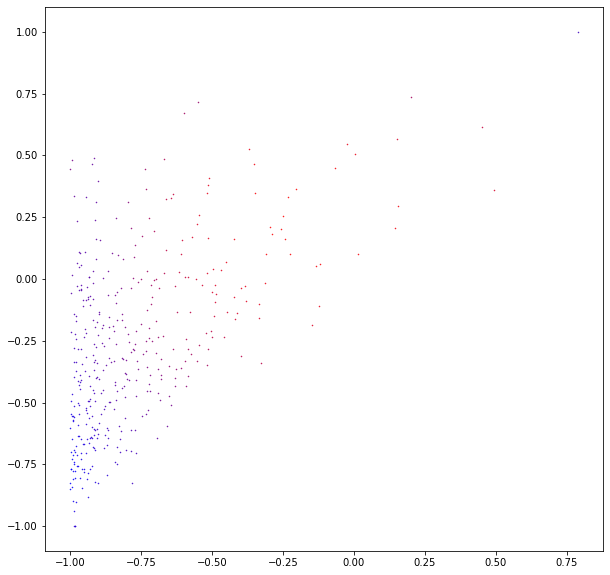

In [24]:
#RESULTING VISUALIZATION
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10)) 

classificator = []
f_m = []
for i in range(0,len(X)):
    f_m.append(f_measuration(counts[i])[0])

Min = min(f_m)
Max = max(f_m)
delta = Max - Min
    
for i in range(0,len(X)):
    x = [X[i]]
    y = [Y[i]]
    plt.plot(x,y,'o',color = [np.clip((f_measuration(counts[i])[0]-Min)/delta,0,1), 0, np.clip(1-(f_measuration(counts[i])[0]-Min)/delta,0,1)] ,markersize = 0.5)

import winsound
frequency = 1000  # Set Frequency To 2500 Hertz
duration = 1000 # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [25]:
#SAVING RESULTS ON A TEXT FILE

file1 = open("real_device_record.txt","a")
FP = str(False_positive_rate).strip('[]')
TP = str(True_positive_rate).strip('[]')
FM = str(f_m).strip('[]')

file1.write("BEGIN ATTEMPT \n\n")
file1.write("number_training = %d \n\n" %number_training)
file1.write("number_testing = %d \n\n" %number_testing)
file1.write("SPSA_steps = %d \n\n" %SPSA_steps)
file1.write("number_var = %d \n\n" %number_var)
file1.write("variables: %d " %ii + "% d " %jj + "%d \n\n" %kk)
file1.write("AUC = %d \n\n" %AUC)

file1.write("False Positives: \n\n"+FP+ "\n\n"+"True Positives: \n\n"+TP+ "\n\n"+"f_measuration: \n\n"+FM + "\n\n\n\n\n")
file1.close() 

NameError: name 'kk' is not defined